In [87]:
# MLB Scraper Top 10 Leaderboard by 90th Percentile Exit Velocity
import pandas as pd
import numpy as np
import polars as pl
from api_scraper import MLB_Scrape

# Set display options to print all columns without truncation
pd.set_option("display.max_columns", None)  # Ensure all columns are displayed
pd.set_option("display.max_rows", None)  # Ensure all rows are displayed
pd.set_option("display.width", None)  # Remove column width limit

In [88]:
# Specified team name
team_name = "Texas Rangers"
# Team name abbreviation
team_abbreviation = "TEX"

In [89]:
# Initialize the scraper
scraper = MLB_Scrape()

# Fetch 2025 Spring Training Games
schedule_df = scraper.get_schedule(year_input=[2025], game_type=['S'])

# Filter for Spring Training games with Statcast for specified tea
schedule_df = schedule_df.filter(
    (((pl.col("home") == team_name) | (pl.col("away") == team_name))
    & ((pl.col("gameday_type") == "E") | (pl.col("gameday_type") == "P")))
)

In [90]:
from datetime import datetime

# Get today's date
today = datetime.today().date()

# Define the start and end dates as date literals
start_date = pl.lit("2025-02-20").str.to_date()
end_date = pl.lit(str(today)).str.to_date()  # Convert today to string before using .str.to_date()

# Filter specified team games for the beginning of Spring Training to current date
team_games_filtered = schedule_df.with_columns(
    pl.col("date").cast(pl.Date).alias("date")  # Convert 'date' column to Date type
).filter(
    pl.col("date").is_between(start_date, end_date)
)

In [91]:
# Get all game_id values from the filtered DataFrame as a list
game_ids = team_games_filtered.select("game_id").to_series().to_list()

# Get live game data using game_list_input
game_data = scraper.get_data(game_list_input=game_ids)

# Convert game_data from JSON to a Polars DataFrame
data_df = scraper.get_data_df(data_list=game_data)

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 15/15 [00:00<00:00, 26.73iteration/s]

Converting Data to Dataframe.


In [92]:
# Filter the DataFrame to get batters data from specified team
team_batters = data_df.filter(pl.col("batter_team") == team_abbreviation)

# Select the batter_id and batter_name columns, then drop duplicates
team_batters_unique = team_batters.select(["batter_id", "batter_name"]).unique()

In [93]:
# Get the list of unique team batters' batter_ids
team_batters_ids = team_batters_unique["batter_id"].to_list()

# Select batter_id, batter_name, and launch_speed, then filter out rows with null launch_speed
team_batters_launch_speed = team_batters.filter(pl.col("launch_speed").is_not_null())

In [94]:
# Selecting necessary columns
team_batters_launch_speed = team_batters_launch_speed.select(
    ["game_date", "batter_id", "batter_name", "launch_speed"]
)

# Find the total number of batted balls for each batter
batted_ball_counts = (
    team_batters_launch_speed
    .group_by("batter_name")
    .agg(pl.col("batter_id").count().alias("batted_ball_count"))
)

# Filter for batters who have had a minimum amount of batted balls
batters_with_min_bb = batted_ball_counts.filter(pl.col("batted_ball_count") >= 10)["batter_name"]

# Filter dataset to include batters who meet the minimum amount of batted balls
team_batters_launch_speed = team_batters_launch_speed.filter(
    pl.col("batter_name").is_in(batters_with_min_bb)
)

game_date,batter_id,batter_name,launch_speed
str,i64,str,f64
"""2025-02-25""",543760,"""Marcus Semien""",88.6
"""2025-02-25""",608369,"""Corey Seager""",101.0
"""2025-02-25""",694497,"""Evan Carter""",106.6
"""2025-02-25""",666969,"""Adolis García""",97.0
"""2025-02-25""",673962,"""Josh Jung""",92.5
…,…,…,…
"""2025-03-08""",669394,"""Jake Burger""",70.7
"""2025-03-08""",543309,"""Kyle Higashioka""",80.7
"""2025-03-08""",694497,"""Evan Carter""",71.7


In [95]:
from decimal import Decimal, ROUND_HALF_UP
# Convert DataFrame from Polars to Pandas for easier data manipulation
team_batters_launch_speed_pd = team_batters_launch_speed.to_pandas()

# Group by batters name and calculate the 90th percentile of launch_speed for each batter
percentiles = team_batters_launch_speed_pd.groupby("batter_id")["launch_speed"].apply(
    lambda x: float(Decimal(str(np.percentile(x.dropna(), 90))).quantize(Decimal("0.1"), rounding=ROUND_HALF_UP))
).reset_index()

# Rename the column for clarity
percentiles = percentiles.rename(columns={"launch_speed": "90th_percentile_exit_velocity"})

# Merge percentiles with batter names
batter_names_df = team_batters_launch_speed_pd[['batter_id', 'batter_name']].drop_duplicates()
percentiles = percentiles.merge(batter_names_df, on="batter_id", how="left")

# Sort by 90th percentile exit velocity in descending order
percentiles_sorted = percentiles.sort_values(by="90th_percentile_exit_velocity", ascending=False).reset_index(drop=True)

percentiles_sorted.rename(columns={
    "batter_name": "Player"
}, inplace=True)

In [96]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import matplotlib.gridspec as gridspec

In [97]:
# Number of top batters to display
len_batters = 10

# Set the number of rows and columns for the subplot grid
num_rows = len_batters + 2  # 10 players + 2 for top and bottom
num_cols = 3  # Three columns: two thin ones on the edges and one main column in the center

In [98]:
# Get the top 10 players
top_10_batters = percentiles_sorted[['batter_id','Player', '90th_percentile_exit_velocity']].head(10)

In [99]:
# List of MLB teams and their corresponding ESPN logo URLs
mlb_teams = [
    {"team_abbreviation": "AZ", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/ari.png&h=500&w=500"},
    {"team_abbreviation": "ATL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/atl.png&h=500&w=500"},
    {"team_abbreviation": "BAL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bal.png&h=500&w=500"},
    {"team_abbreviation": "BOS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bos.png&h=500&w=500"},
    {"team_abbreviation": "CHC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chc.png&h=500&w=500"},
    {"team_abbreviation": "CWS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chw.png&h=500&w=500"},
    {"team_abbreviation": "CIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cin.png&h=500&w=500"},
    {"team_abbreviation": "CLE", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cle.png&h=500&w=500"},
    {"team_abbreviation": "COL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/col.png&h=500&w=500"},
    {"team_abbreviation": "DET", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/det.png&h=500&w=500"},
    {"team_abbreviation": "HOU", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/hou.png&h=500&w=500"},
    {"team_abbreviation": "KC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/kc.png&h=500&w=500"},
    {"team_abbreviation": "LAA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/laa.png&h=500&w=500"},
    {"team_abbreviation": "LAD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/lad.png&h=500&w=500"},
    {"team_abbreviation": "MIA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mia.png&h=500&w=500"},
    {"team_abbreviation": "MIL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mil.png&h=500&w=500"},
    {"team_abbreviation": "MIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/min.png&h=500&w=500"},
    {"team_abbreviation": "NYM", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nym.png&h=500&w=500"},
    {"team_abbreviation": "NYY", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nyy.png&h=500&w=500"},
    {"team_abbreviation": "OAK", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/oak.png&h=500&w=500"},
    {"team_abbreviation": "PHI", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/phi.png&h=500&w=500"},
    {"team_abbreviation": "PIT", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/pit.png&h=500&w=500"},
    {"team_abbreviation": "SD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sd.png&h=500&w=500"},
    {"team_abbreviation": "SF", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sf.png&h=500&w=500"},
    {"team_abbreviation": "SEA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sea.png&h=500&w=500"},
    {"team_abbreviation": "STL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/stl.png&h=500&w=500"},
    {"team_abbreviation": "TB", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tb.png&h=500&w=500"},
    {"team_abbreviation": "TEX", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tex.png&h=500&w=500"},
    {"team_abbreviation": "TOR", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tor.png&h=500&w=500"},
    {"team_abbreviation": "WSH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/wsh.png&h=500&w=500"}
]

# Look for the team in the mlb_teams list and get the corresponding logo URL
logo_url = next((team["logo_url"] for team in mlb_teams if team["team_abbreviation"] == team_abbreviation), None)

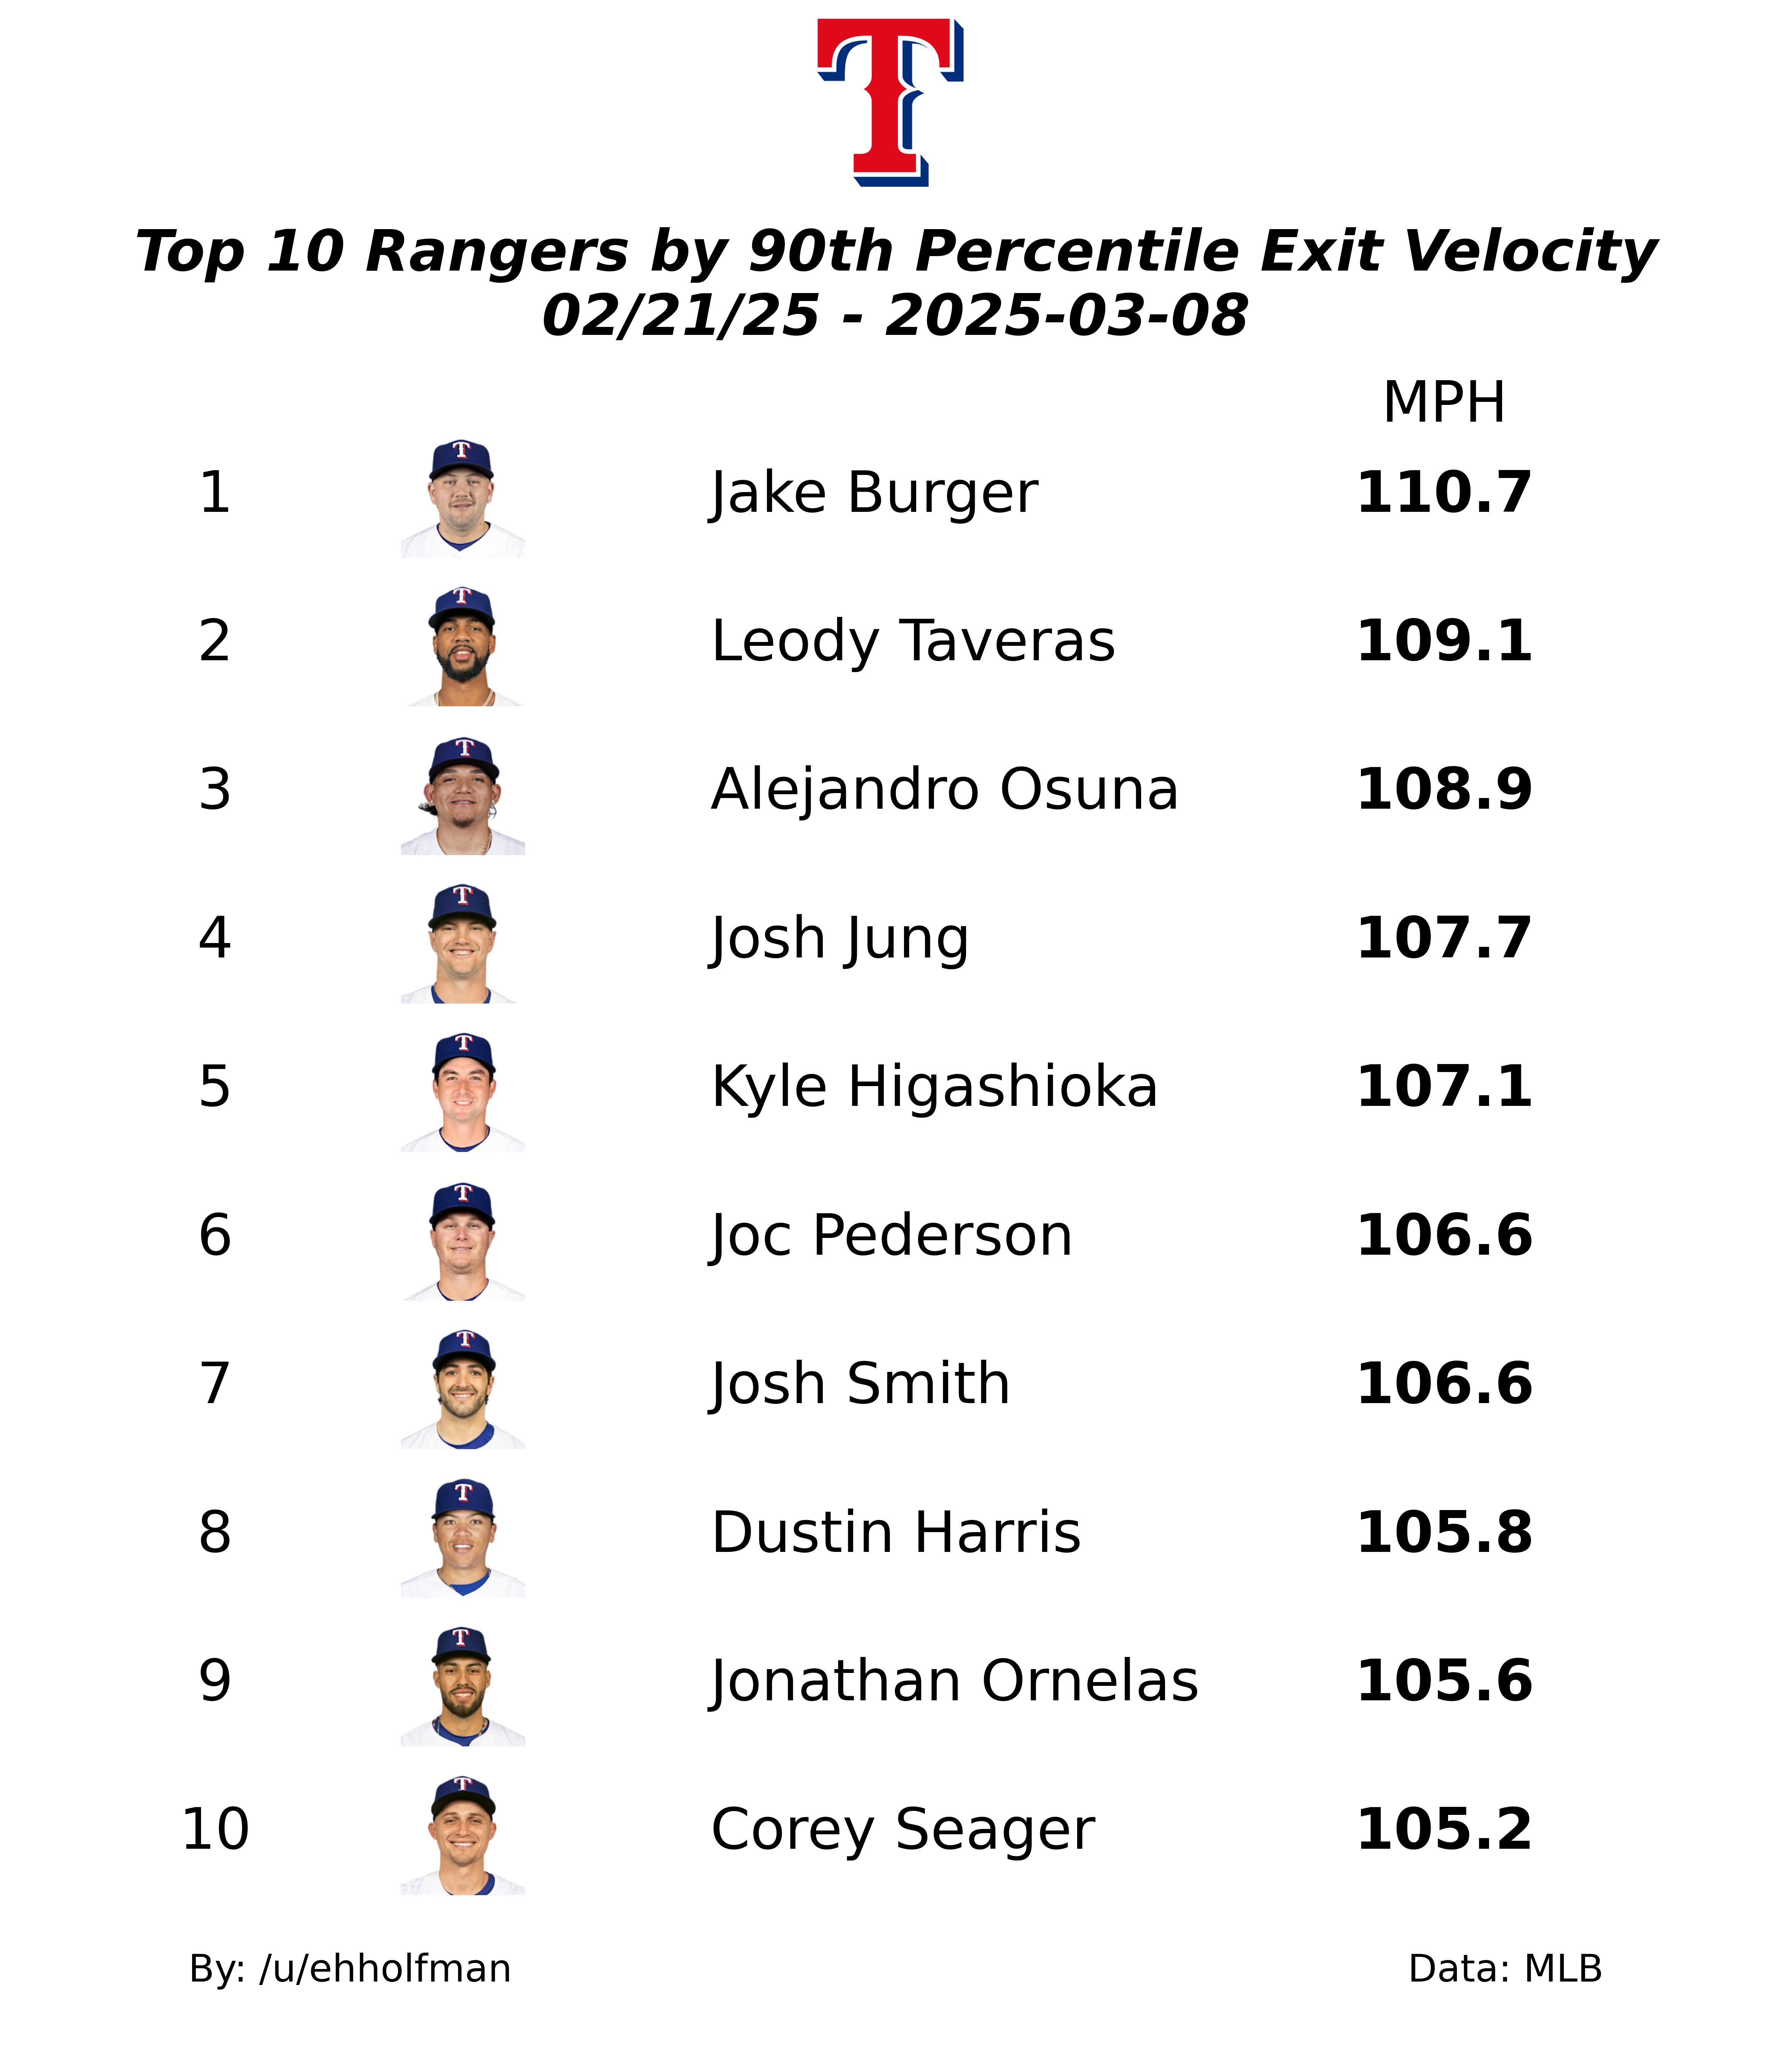

In [100]:
# Create a figure
fig = plt.figure(figsize=(20, 20), dpi=300)

# Get today's date for graphic labeling
today_date = datetime.today().strftime('%m/%d/%Y')

# Create a GridSpec object with different widths for the columns
gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, width_ratios=[0.5, 9, 0.5])

# A grid that can be uncommented and used to check alignment/formatting
'''
# Create a main axis spanning the entire figure
ax_main = fig.add_subplot(111)  # This axis covers the entire figure
ax_main.set_xlim(0, 1)
ax_main.set_ylim(0, 1)

# Add two lines (vertical and horizontal) for centering the content over the whole figure
ax_main.plot([0.5, 0.5], [0, 1], color='gray', linewidth=2)  # Vertical line at x=0.5
ax_main.plot([0, 1], [0.5, 0.5], color='gray', linewidth=2)  # Horizontal line at y=0.5

# Hide the axes of the main plot (since it's just for the grid)
#ax_main.axis('off')

'''

# Step 1: Add the 'picture' column with URLs based on batter IDs
top_10_batters['picture'] = top_10_batters['batter_id'].apply(
    lambda i: f'https://img.mlbstatic.com/mlb-photos/image/upload/w_180,d_people:generic:headshot:silo:current.png,q_auto:best,f_auto/v1/people/{i}/headshot/silo/current'
)

# Define the positions for the top 10 players in the grid
positions = [(i + 1, 1) for i in range(len_batters)]

# Iterate over the top 10 players in the sorted dataframe
for i, (_, team_row) in enumerate(top_10_batters.iterrows()):
    player = team_row['Player']
    headshot_url = team_row['picture']

    # Determine the position in the grid (row, col) based on rank
    row, col = positions[i]

    # Create a subplot in the GridSpec layout
    ax = fig.add_subplot(gs[row, col])

    # Plot the player's headshot
    response = requests.get(headshot_url)
    img = Image.open(BytesIO(response.content))
    ax.set_xlim(-1, 1)
    ax.imshow(img, extent=[-0.8, -0.6, 0, 1], aspect=0.2)
    ax.axis('off')

    # Add the rank number to the left of the logo, italicized
    ax.text(-0.05, 0.5, f'{i+1}', transform=ax.transAxes, ha='center', va='center', fontsize=36)

    # Add the player name and exit velocity metric value
    ax.text(0.35, 0.5, f'{player}', transform=ax.transAxes, ha='left', va='center', fontsize=36)
    ax.text(0.87, 0.5, f'{team_row["90th_percentile_exit_velocity"]}', transform=ax.transAxes, ha='left',va='center', fontsize=36, weight='bold')

# Adjust the spacing between subplots
ax_top = fig.add_subplot(gs[0, :])
ax_bot = fig.add_subplot(gs[-1, :])
ax_left = fig.add_subplot(gs[:, 0])
ax_right = fig.add_subplot(gs[:, -1])

ax_top.axis('off')
ax_bot.axis('off')
ax_left.axis('off')
ax_right.axis('off')

# Add the team logo to the title area
ax_logo = fig.add_axes([0.47, 0.92, 0.08, 0.08])  # [left, bottom, width, height]

response = requests.get(logo_url)
team_logo = Image.open(BytesIO(response.content))
ax_logo.imshow(team_logo)
ax_logo.axis('off')

# Add text annotations at the bottom
ax_bot.text(s='By: /u/ehholfman', x=0.1, y=0.5, fontsize=24, ha='left')
ax_bot.text(s='Data: MLB', x=0.9, y=0.5, fontsize=24, ha='right')

# Add the title at the top
ax_top.text(s=f"Top 10 Rangers by 90th Percentile Exit Velocity\n02/21/25 - {today}", x=0.5, y=0.6, fontsize=36, ha='center', style='italic', weight='bold')

# Add the title at the top
ax_top.text(s=f'MPH', x=0.81, y=-0.1, fontsize=36, ha='center')

# Save the graphic if desired
#plt.savefig('Top_10_Rangers_EV90.png', bbox_inches='tight', dpi=300)

# Show the grapic
plt.show()